# MAP推定

最大事後確率（*Maximum a posteriori*）推定。あるデータ$X$が得られた時、事後確率が最も高くなるパラメータ$\theta$を推定する。

$$
\argmax_{\theta} p(\theta|X)
$$

In [29]:
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import random

まず、MAP推定を学ぶ上で必要な概念を理解する。


---

## ベイズの定理

条件付き確率に関する以下の公式。

$$
p(A|B) = \frac{p(B|A)p(A)}{p(B)}
$$

A,Bは何らかの事象。Aが原因でBを結果だとすると、原因Aの元で結果Bが起きる確率$p(B|A)$という求めやすい値から、その逆の確率$P(A|B)$を求められる。$p(A)$は事前分布、$p(A|B)$は事後分布と呼ぶ。


---

## 事後分布

データ$X$とパラメータ$\theta$でもベイズの定理を適用することができる。

$$
p(\theta|X) = \frac{p(X|\theta)p(\theta)}{p(X)}
$$

- $p(\theta|X)$: 事後分布。データ$X$が得られた時、そのデータがパラメータ$\theta$（に従う分布）から生成された確率。
- $p(X|\theta)$: 尤度。パラメータ$\theta$の下でデータ$X$が得られる確率。
- $p(\theta)$: 事前分布。パラメータ$\theta$が得られる確率。
- $p(X)$: 周辺尤度: $p(X)=\int p(\theta)p(X|\theta) d\theta$。データ$X$が得られる確率。

<br>

MAP推定を行う際は、↑のようにベイズの定理を用いて式を変換する。

$$
\begin{align}
\argmax_{\theta} p(\theta|X) &= \argmax_{\theta} \frac{p(X|\theta)p(\theta)}{p(X)} \\
&= \argmax_{\theta} p(X|\theta)p(\theta) \\
\end{align}
$$

最尤推定で求めたものは以下であった。

$$
\argmax_{\theta} p(X|\theta)
$$

MAP推定では、**パラメータ$\theta$も確率変数とみなし**、$X$の尤度$p(X|\theta)$だけでなくそのパラメータ$\theta$が得られる確率（厳密には尤度）$p(\theta)$も考慮して$\theta$を推定する。  
事後分布は、$X$の尤度を$\theta$の尤度で重み付けしたものというイメージ。

また$p(\theta)$は事前分布と呼ばれ、**主観的**な知見を反映させるがある。


---

## 総当たりで求める

では実際にMAP推定を行ってみる。  
$\theta$の値を全て試して、事後確率が最大になる$\theta$を求める。（ここでの事後確率は、事後分布に具体的な$X, \theta$を代入した時に出てきた値という意味。）

例題

> 東京都に住む成人男性の平均身長を求めたい。アンケートを実施して、10000の標本を集めることができた。この10000人分のデータを元に、平均身長を求める。具体的には、身長が正規分布に従うと仮定し、その分布の平均値を求める。なお標準偏差は既知で$\sigma=10$とする。また、日本の成人男性の身長が平均170cm、標準偏差10cmの正規分布に従うことを知っているとする。

<br>

以下のような標本が得られたとしよう。

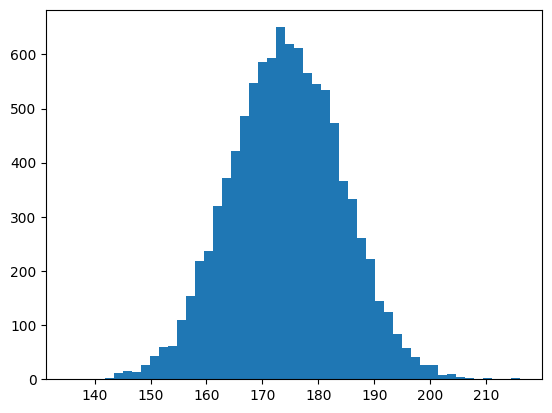

In [37]:
norm = dist.Normal(174, 10)
x = norm.sample((10000,))
plt.hist(x, bins=50);

この標本は平均174、標準偏差10の正規分布から得られている。

では実際に総当たりで求めていく。ただ今回は確率変数$x$（身長）が連続値で範囲が正の実数なので、適当に範囲と分解能を決めて離散化する。

In [38]:
theta = torch.arange(160, 180, 0.1) # 160~180までを0.1刻みで

次に事前分布を決める。今回は、日本の成人男性の身長の分布を知っているという設定がある。そしてそれはパラメータ$\theta$の事前分布として適しているだろうと考えられる。これは主観的な知見にあたる。

ということで、事前分布は日本の成人男性の身長の分布$\mathcal N(170, 10)$とする。

In [31]:
prior = dist.Normal(170, 10)

あとは計算をするだけ。

$$
\begin{align}
\argmax_{\theta} p(\theta|X) &= \argmax_{\theta} \frac{p(X|\theta)p(\theta)}{p(X)} \\
&= \argmax_{\theta} p(X|\theta)p(\theta) \\
\end{align}
$$

より、各$\theta$で以下を求め、最も大きくなった$\theta$を見つける。

$$
p(X|\theta)p(\theta)
$$

MAP推定値: 172.10000610351562


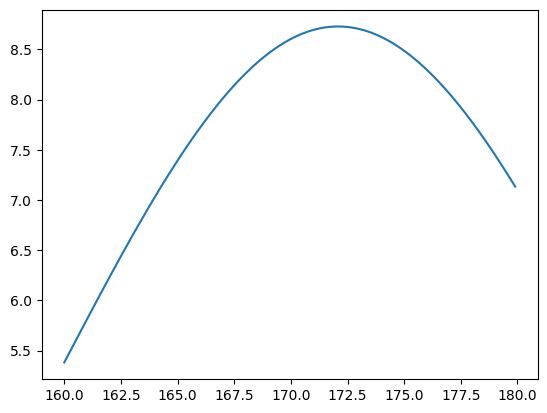

In [43]:
y = []
for t in theta:
    likelihood = dist.Normal(t, 10).log_prob(x).exp()
    prior_prob = prior.log_prob(x).exp()
    y_ = likelihood * prior_prob
    y.append(y_.sum().item())
print("MAP推定値:", theta[np.argmax(y)].item())
plt.plot(theta, y);

推定結果は172.1となった。